In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

/home/anson/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Loading Data

In [2]:
cm = 3
mN = 1
V2 = 1e-2    # used in reweighting the samples

In [3]:
df_eff = pd.read_csv("../data/eff.csv")
df_eff

,Type,Energy,Mass,Efficiency
0,b_aMu_qql,3,NaN,0.003872
1,b_MuMu_qqlv,3,NaN,0.044162
2,b_MuMu_qqll,3,NaN,0.003830
3,b_aa_qqlv,3,NaN,0.164548
4,b_aMu_qqv,3,NaN,0.000000
5,s_M,3,1000.0,0.544380
6,s_D,3,1000.0,0.557311


In [4]:
# extract the reconstruction eff from the eff table

eff_M = df_eff[(df_eff.Energy==cm) & (df_eff.Mass==mN*1000) & (df_eff.Type=='s_M')]['Efficiency'].values[0]
eff_D = df_eff[(df_eff.Energy==cm) & (df_eff.Mass==mN*1000) & (df_eff.Type=='s_D')]['Efficiency'].values[0]
eff_baMu_qql = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_aMu_qql')]['Efficiency'].values[0]
eff_baMu_qqv = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_aMu_qqv')]['Efficiency'].values[0]
eff_bMuMu_qqlv = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_MuMu_qqlv')]['Efficiency'].values[0]
eff_bMuMu_qqll = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_MuMu_qqll')]['Efficiency'].values[0]
eff_baa_qqlv = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_aa_qqlv')]['Efficiency'].values[0]

In [5]:
# store the muon collider luminosity, Xsec, for later estimating the yields

Lumi = 1000000

V2_sim = 0.2**2

# corss section when |V|^2 = 1
Xsec_M = {3: {1: 3.70E+00 / V2_sim}}    # first key: sqrt{s}, second key: m_N
Xsec_D = {3: {1: 3.76E+00 / V2_sim}}
Xsec_baMu_qql = {3: 3.83E+00}   # key: sqrt{s}
Xsec_baMu_qqv = {3: 1.02E+01}
Xsec_bMuMu_qqlv = {3: 6.03E+00}
Xsec_bMuMu_qqll = {3: 3.16E+00}
Xsec_baa_qqlv = {3: 3.88E-01}

In [6]:
# read the files, and calculate the corresponding yields

modes_dt = {
            1: {'mode': f'../data/features/sig_Maj_E-{cm}_m-{mN*1000}_reco.root', 'yields': Lumi*Xsec_M[cm][mN]*eff_M*V2},
            2: {'mode': f'../data/features/sig_Dir_E-{cm}_m-{mN*1000}_reco.root', 'yields': Lumi*Xsec_D[cm][mN]*eff_D*V2}, 
            3: {'mode': f'../data/features/bg_aMu_qql_E-3_reco.root', 'yields': Lumi*Xsec_baMu_qql[cm]*eff_baMu_qql},
            4: {'mode': f'../data/features/bg_aMu_qqv_E-3_reco.root', 'yields': Lumi*Xsec_baMu_qqv[cm]*eff_baMu_qqv},
            5: {'mode': f'../data/features/bg_MuMu_qqlv_E-3_reco.root', 'yields': Lumi*Xsec_bMuMu_qqlv[cm]*eff_bMuMu_qqlv},
            6: {'mode': f'../data/features/bg_MuMu_qqll_E-3_reco.root', 'yields': Lumi*Xsec_bMuMu_qqll[cm]*eff_bMuMu_qqll},
            7: {'mode': f'../data/features/bg_aa_qqlv_E-3_reco.root', 'yields': Lumi*Xsec_baa_qqlv[cm]*eff_baa_qqlv}
           }

In [7]:
for k, v in modes_dt.items():
    print(f"{v['yields']:.2e}")

5.04e+05
5.24e+05
1.48e+04
0.00e+00
2.66e+05
1.21e+04
6.38e+04


In [8]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        file = uproot.open(v['mode'])
        print("reading: ", v['mode'])
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        df_i['target'] = k    # add the target label
        df_i['weight'] = v['yields']/len(df_i)
#         print(k, v)
        num_lt.append(len(df_i))

        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('\ntrain size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [9]:
tr_te_size = 0.5 
df_train, df_test = load_train_test(modes_dt, tr_te_size)

df_train_o, df_test_o = df_train.copy(), df_test.copy()

reading:  ../data/features/sig_Maj_E-3_m-1000_reco.root
reading:  ../data/features/sig_Dir_E-3_m-1000_reco.root
reading:  ../data/features/bg_aMu_qql_E-3_reco.root
reading:  ../data/features/bg_aMu_qqv_E-3_reco.root
reading:  ../data/features/bg_MuMu_qqlv_E-3_reco.root
reading:  ../data/features/bg_MuMu_qqll_E-3_reco.root
reading:  ../data/features/bg_aa_qqlv_E-3_reco.root

train size: 203664 (50.00%); test size: 203660 (50.00%)
data points per mode:  [271253, 27865, 1936, 0, 22081, 1915, 82274]


### Prepare for BDT

In [10]:
def relabel(x):
    if x != 1 and x != 2:    # bkg
        return 0
    
    elif x == 1:     # Maj signal
        return 1
    
    elif x == 2:     # Dir signal
        return 2

In [11]:
features = ['ptLep', 'etaLep', 'ELep',      # lepton kinematics info 
            'chargeLep', 'lepisMu',         # lepton type info
            'DeltaPhijjl', 'DeltaRjjl',     # Delta phi & Delta R between jj(from W boson) and lepton
            'ptJJ', 'etaJJ', 'mJJ',         # jj(from W boson) momentum info
            'ptN', 'pzN',                   # reconstructed N 4 momentum info
            'EJet1', 'EJet2',               # energy inbalance of the jets, for W boson classification
            'ptFwMu'                        # Forward muon pT
           ]


In [12]:
# # relabel the, all bkg become one label
df_train['target'] = df_train['target'].apply(relabel)
df_test['target'] = df_test['target'].apply(relabel)

In [13]:
# trainging
X_train = df_train[features]
y_train = df_train['target']

# testing
X_test = df_test[features]
y_test = df_test['target']


In [14]:
np.unique(y_train)

array([0, 1, 2])

In [15]:

# fitting, with reweighting
xgbc1 = xgb.XGBClassifier(seed=0)
xgbc1.fit(X_train, y_train, sample_weight=df_train.weight.values);
# xgbc1.fit(X_train, y_train);

In [16]:
# the "preds" means the prob. of the event being HNL (Maj/Dir)
# since the 0 index is the bkg, so the prob. of HNL is 1 - prob. of bkg

# scores for training
df_bdt_train_s = df_train[['target', 'weight']]
df_bdt_train_s.loc[:, 'preds'] = 1 - xgbc1.predict_proba(X_train)[:, 0]

# score for testing 
df_bdt_test_s = df_test[['target', 'weight']]
df_bdt_test_s.loc[:, 'preds'] = 1 - xgbc1.predict_proba(X_test)[:, 0]


In [17]:
def bdt_cut(df, cut):
    df1 = df[(df['preds'] >= cut)]    # pass cut to be classified as HNL
#    "/ 2" because the samples include M & D. now assume they are just half half
    S1 = df1[df1['target'] != 0]['weight'].values.sum() / 2    # Number of signals
    B1 = df1[df1['target'] == 0]['weight'].values.sum()    # Number of bkg.
    return ((S1+B1)**0.5, (0.1*B1), S1/(np.sqrt(S1+B1)))




# looping to find the optimal cut
def find_opt_cut(df_bdt_train_s, step=0.01):
    # cuts
    cuts = np.arange(0, 1, step)
    
    # store cuts
    c_lt = []
    # store losses
    loss1, loss2 = [], []
    snr = []

    # loop over two cuts
    for i1, c1 in enumerate(cuts):
        print("{}/{}".format(i1, len(cuts)), end='\r')
        res = bdt_cut(df_bdt_train_s, c1)
        c_lt.append(c1)    
        loss1.append(res[0])
        loss2.append(res[1])
        snr.append(res[2])
        
    # store the cuts and corresponding losses
    df_bdt_loss = pd.DataFrame([c_lt, loss1, loss2, snr]).T
    df_bdt_loss.columns = ['c', 'loss1', 'loss2', 'snr']

    df_bdt_loss['loss'] = (df_bdt_loss['loss1']**2 + df_bdt_loss['loss2']**2)**0.5
    df_bdt_loss['tot'] = (df_bdt_loss['loss'] - df_bdt_loss['loss'].min())/(df_bdt_loss['loss'].max() - df_bdt_loss['loss'].min()) - \
                        ((df_bdt_loss['snr'] - df_bdt_loss['snr'].min())/(df_bdt_loss['snr'].max() - df_bdt_loss['snr'].min()))
    
    return df_bdt_loss.iloc[df_bdt_loss['tot'].argmin()][['c']].values

In [18]:
# the optimal threshold
threshold = find_opt_cut(df_bdt_train_s)[0]

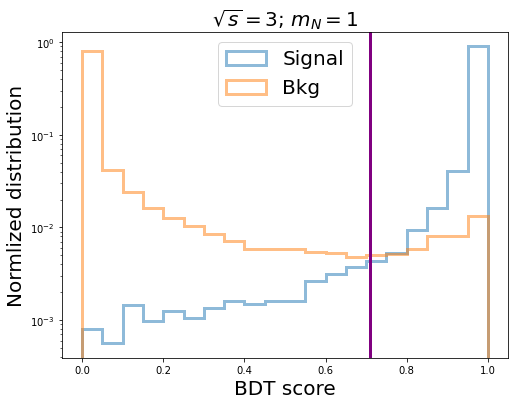

In [19]:
# BDT score distribution 

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

df_plot = df_bdt_test_s
# df_plot = df_bdt_train_s

range_=[0, 1]
bins_=20

ax1.hist(df_plot[df_plot.target!=0]['preds'], weights=df_plot[df_plot.target!=0]['weight']/sum(df_plot[df_plot.target!=0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.hist(df_plot[df_plot.target==0]['preds'], weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg', alpha=0.5);

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=9, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
ax1.axvline(threshold, color='purple', lw=3)

ax1.set_yscale('log')




# =================================================================================
# Apply BDT score cut
df_bdt_cut = df_bdt_test_s[(df_bdt_test_s['preds'] >= threshold)]
# =================================================================================



In [20]:
# separate to Maj/Dir/bkg

df_bdt_cut['iEvt'] = df_test_o.loc[df_bdt_cut.index]['iEvt']
df_bdt_cut['mN'] = df_test_o.loc[df_bdt_cut.index]['mN']
df_bdt_cut['lepisEle'] = df_test_o.loc[df_bdt_cut.index]['lepisEle']
df_bdt_cut['lepisMu'] = df_test_o.loc[df_bdt_cut.index]['lepisMu']
df_bdt_cut1 = df_bdt_cut[(df_bdt_cut['target'] == 1)]
df_bdt_cut2 = df_bdt_cut[(df_bdt_cut['target'] == 2)]
df_bdt_cut0 = df_bdt_cut[(df_bdt_cut['target'] != 1) & (df_bdt_cut['target'] != 2)]


Mass range: [950.0, 1025.0]


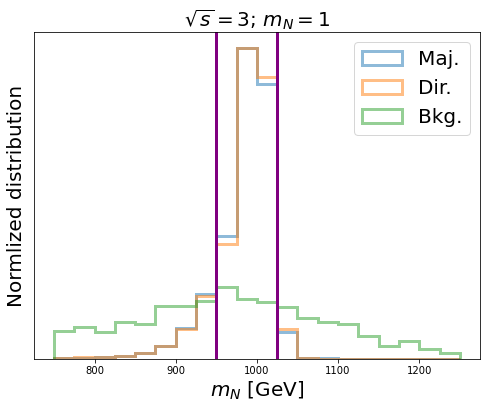

In [21]:
# mN distribution after BDT cut

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

range_ = [mN*(1-0.25)*1000, mN*(1+0.25)*1000]

bins_=20
ax1.hist(df_bdt_cut1['mN'], weights=[1/len(df_bdt_cut1)]*len(df_bdt_cut1), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Maj.', color='C0');
ax1.hist(df_bdt_cut2['mN'], weights=[1/len(df_bdt_cut2)]*len(df_bdt_cut2), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Dir.', color='C1');
ax1.hist(df_bdt_cut0['mN'], weights=[1/len(df_bdt_cut0)]*len(df_bdt_cut0), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Bkg.', color='C2');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m_N ~[\rmGeV]$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)

# mass range cut
partition_u = 0.025
partition_l = 0.05
ax1.axvline(1000*mN*(1-partition_l), color='purple', lw=3)
ax1.axvline(1000*mN*(1+partition_u), color='purple', lw=3)

print("Mass range: [{}, {}]".format(1000*mN*(1-partition_l), 1000*mN*(1+partition_u)))

# f.savefig('./figures/mN')

# =========================================================================================
# manully apply cut on mN
df_bdt_cut['mN'] = df_test_o.loc[df_bdt_cut.index]['mN']
df_bdt_cut = df_bdt_cut[(df_bdt_cut.mN>=1000*mN*(1-partition_l)) & (df_bdt_cut.mN<=1000*mN*(1+partition_u))]
# =========================================================================================


In [22]:
# yields after BDT and mass cuts

df_bdt_cut0 = df_bdt_cut[(df_bdt_cut['target'] == 0)]   # Bkg
df_bdt_cut1 = df_bdt_cut[(df_bdt_cut['target'] == 1)]   # M
df_bdt_cut2 = df_bdt_cut[(df_bdt_cut['target'] == 2)]   # D

# yield (without |V|^2 dependence)
nb = df_bdt_cut0.weight.sum() / tr_te_size          # Bkg
nM = df_bdt_cut1.weight.sum() / tr_te_size / V2    # M
nD = df_bdt_cut2.weight.sum() / tr_te_size / V2    #  D

print('yields: ')
print(f'Bkg:\t{nb:.2e}')
print(f'(M):\t{nM:.2e} x |V|^2')
print(f'(D):\t{nD:.2e} x |V|^2')

yields: 
Bkg:	4.49e+03
(M):	4.09e+07 x |V|^2
(D):	4.19e+07 x |V|^2


In [23]:
# eff. of the BDT and mass cuts

eff0 = len(df_bdt_cut0) / len(df_test_o[(df_test_o.target!=1) & (df_test_o.target!=2)])
eff1 = len(df_bdt_cut1) / len(df_test_o[df_test_o.target==1])
eff2 = len(df_bdt_cut2) / len(df_test_o[df_test_o.target==2])

print("BDT eff:")
print("bkg:\t{:2f}%".format(100*eff0))
print("Maj:\t{:2f}%".format(100*eff1))
print("Dir:\t{:2f}%".format(100*eff2))

BDT eff:
bkg:	0.543418%
Maj:	81.260968%
Dir:	80.053115%


In [24]:
# limits on |V|^2

N = 1.96
M = N**2

print('Fully Majorana case:')
upperM, lowerM = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nM), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nM)
print(f"upper limit on |V|^2: {upperM:.2e}")
print(f"lower limit on |V|^2: {lowerM:.2e}")
print()

print('Fully Dirac case:')
upperD, lowerD = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nD), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nD)
print(f"upper limit on |V|^2: {upperD:.2e}")
print(f"lower limit on |V|^2: {lowerD:.2e}")

Fully Majorana case:
upper limit on |V|^2: 3.26e-06
lower limit on |V|^2: -3.16e-06

Fully Dirac case:
upper limit on |V|^2: 3.18e-06
lower limit on |V|^2: -3.09e-06


In [25]:
# s/b ratio

print("s/b ratio: ")
print(f'# Maj signal / bkg = {nM/nb:.0f} x |V|^2')
print(f'# Dir signal / bkg = {nD/nb:.0f} x |V|^2')

s/b ratio: 
# Maj signal / bkg = 9117 x |V|^2
# Dir signal / bkg = 9344 x |V|^2


In [26]:
# s/sqrt(b)

print("s/sqrt(b) ratio: ")
print(f'# Maj signal / sqrt(bkg) = {nM/(nb)**0.5:.0f} x |V|^2')
print(f'# Dir signal / sqrt(bkg) = {nD/(nb)**0.5:.0f} x |V|^2')

s/sqrt(b) ratio: 
# Maj signal / sqrt(bkg) = 610781 x |V|^2
# Dir signal / sqrt(bkg) = 625964 x |V|^2


In [27]:
# importance of the features used in BDT
d = xgbc1.get_booster().get_score()
dict(sorted(d.items(), key=lambda item: -1*item[1]))

{'pzN': 1611.0,
 'ptJJ': 1423.0,
 'DeltaRjjl': 1269.0,
 'ELep': 1235.0,
 'ptN': 1228.0,
 'ptLep': 1190.0,
 'DeltaPhijjl': 935.0,
 'etaJJ': 913.0,
 'mJJ': 909.0,
 'etaLep': 848.0,
 'chargeLep': 244.0,
 'lepisMu': 176.0,
 'ptFwMu': 96.0}

## Lepton types

In [28]:
# after preselection, before BDT
df_reco = pd.concat([df_train, df_test])
df_reco_e = df_reco[df_reco.lepisEle==1]
df_reco_mu = df_reco[df_reco.lepisMu==1]

In [29]:
print("\nAfter preselection (before BDT)")

print("\n"+"="*20)
print("l = e / mu")
print("Maj.:\t{:.2e} x |V|^2".format(df_reco[df_reco.target==1]['weight'].sum() / V2))
print("Dir.:\t{:.2e} x |V|^2".format(df_reco[df_reco.target==2]['weight'].sum() / V2))
print("Bkg.:\t{:.2e}".format(df_reco[df_reco.target==0]['weight'].sum()))

print("\n"+"="*20)
print("l = e")
print("Maj.:\t{:.2e} x |V|^2".format(df_reco_e[df_reco_e.target==1]['weight'].sum() / V2))
print("Dir.:\t{:.2e} x |V|^2".format(df_reco_e[df_reco_e.target==2]['weight'].sum() / V2))
print("Bkg.:\t{:.2e}\t({:.2f}%)".format(df_reco_e[df_reco_e.target==0]['weight'].sum(), 
                                       100 * df_reco_e[df_reco_e.target==0]['weight'].sum() / df_reco[df_reco.target==0]['weight'].sum()))

print("\n"+"="*20)
print("l = mu")
print("Maj.:\t{:.2e} x |V|^2".format(df_reco_mu[df_reco_mu.target==1]['weight'].sum() / V2))
print("Dir.:\t{:.2e} x |V|^2".format(df_reco_mu[df_reco_mu.target==2]['weight'].sum() / V2))
print("Bkg.:\t{:.2e}\t({:.2f}%)".format(df_reco_mu[df_reco_mu.target==0]['weight'].sum(), 
                                       100 * df_reco_mu[df_reco_mu.target==0]['weight'].sum() / df_reco[df_reco.target==0]['weight'].sum()))


After preselection (before BDT)

l = e / mu
Maj.:	5.04e+07 x |V|^2
Dir.:	5.24e+07 x |V|^2
Bkg.:	3.57e+05

l = e
Maj.:	2.35e+07 x |V|^2
Dir.:	2.43e+07 x |V|^2
Bkg.:	4.15e+04	(11.61%)

l = mu
Maj.:	2.69e+07 x |V|^2
Dir.:	2.81e+07 x |V|^2
Bkg.:	3.16e+05	(88.39%)


In [30]:
# after BDT and mass cut
df_bdt_e = df_bdt_cut[df_bdt_cut.lepisEle==1]
df_bdt_mu = df_bdt_cut[df_bdt_cut.lepisMu==1]

In [31]:
N_M_e = df_bdt_e[df_bdt_e.target==1]['weight'].sum() / V2
N_M_mu = df_bdt_mu[df_bdt_mu.target==1]['weight'].sum() / V2 

N_D_e = df_bdt_e[df_bdt_e.target==2]['weight'].sum() / V2
N_D_mu = df_bdt_mu[df_bdt_mu.target==2]['weight'].sum() / V2 

B_e = df_bdt_e[df_bdt_e.target==0]['weight'].sum()
B_mu = df_bdt_mu[df_bdt_mu.target==0]['weight'].sum()


N_e = N_M_e
N_mu = N_M_mu

In [32]:
print("\nAfter BDT")

print("\n"+"="*20)
print("l = e / mu")
print("Maj.:\t{:.2e} x |V|^2".format(df_bdt_cut[df_bdt_cut.target==1]['weight'].sum() / V2))
print("Dir.:\t{:.2e} x |V|^2".format(df_bdt_cut[df_bdt_cut.target==2]['weight'].sum() / V2))
print("Bkg.:\t{:.2e}".format(df_bdt_cut[df_bdt_cut.target==0]['weight'].sum()))

print("\n"+"="*20)
print("l = e")
print("Maj.:\t{:.2e} x |V|^2".format(N_M_e))
print("Dir.:\t{:.2e} x |V|^2".format(N_D_e))
print("Bkg.:\t{:.2e}\t({:.2f}%)".format(B_e, 
                                       100 * B_e / df_bdt_cut[df_bdt_cut.target==0]['weight'].sum()))

print("\n"+"="*20)
print("l = mu")
print("Maj.:\t{:.2e} x |V|^2".format(N_M_mu))
print("Dir.:\t{:.2e} x |V|^2".format(N_D_mu))
print("Bkg.:\t{:.2e}\t({:.2f}%)".format(B_mu, 
                                       100 * B_mu / df_bdt_cut[df_bdt_cut.target==0]['weight'].sum()))


After BDT

l = e / mu
Maj.:	2.05e+07 x |V|^2
Dir.:	2.10e+07 x |V|^2
Bkg.:	2.24e+03

l = e
Maj.:	9.66e+06 x |V|^2
Dir.:	9.79e+06 x |V|^2
Bkg.:	5.20e+01	(2.32%)

l = mu
Maj.:	1.08e+07 x |V|^2
Dir.:	1.12e+07 x |V|^2
Bkg.:	2.19e+03	(97.68%)


In [33]:
Ve2_true, Vmu2_true = 1e-4, 1e-4

pcte = 0.015
pctmu = 0.015
Ve2 = 10**(np.linspace(np.log10(Ve2_true)*(1-pcte), np.log10(Ve2_true)*(1+pcte), 1000))
Vmu2 = 10**(np.linspace(np.log10(Vmu2_true)*(1-pctmu), np.log10(Vmu2_true)*(1+pctmu), 1000))


In [34]:
def cal_lnP(Ve2, Vmu2, Ve2_true, Vmu2_true, Ne, Be, Nmu, Bmu):
    lmbd_e = (Ve2 * Vmu2)/(Ve2 + Vmu2) * Ne + Be
    lmbd_mu = (Vmu2 * Vmu2)/(Ve2 + Vmu2) * Nmu + Bmu
    k_e = (Ve2_true * Vmu2_true)/(Ve2_true + Vmu2_true) * Ne + Be
    k_mu = (Vmu2_true * Vmu2_true)/(Ve2_true + Vmu2_true) * Nmu + Bmu
    
    lnP_e = (k_e - lmbd_e) + k_e * np.log(lmbd_e/k_e)
    lnP_mu = (k_mu - lmbd_mu) + k_mu * np.log(lmbd_mu/k_mu)
    
    return lnP_e + lnP_mu    

In [35]:

lnP = []
for Vmu2i in Vmu2:
    lnPi = cal_lnP(Ve2, Vmu2i, Ve2_true, Vmu2_true, N_e, B_e, N_mu, B_mu)
    lnP.append(lnPi)
lnP = np.array(lnP)

lnP_05 = lnP + 1/2

In [36]:
Ve2_1sd = []
Vmu2_1sd_u = []
Vmu2_1sd_l = []

for i, Ve2i in enumerate(Ve2):
    if (abs(lnP_05[i]).min()/0.5 > 1/100):
        continue
    Ve2_1sd.append(Ve2i)
    Vmu2_1sd_u.append(Vmu2[int(lnP_05.shape[1]/2)+np.argmin(abs(lnP_05[i, int(lnP_05.shape[1]/2):]))])
    Vmu2_1sd_l.append(Vmu2[np.argmin(abs(lnP_05[i, :int(lnP_05.shape[1]/2)]))])


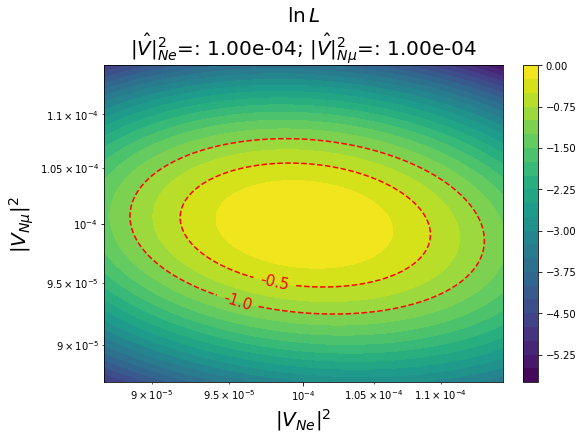

In [37]:
fig1, ax2 = plt.subplots(constrained_layout=True, figsize=(8,6))


CS = ax2.contourf(Ve2, Vmu2, lnP, 25)

ax2.set_xscale('log')
ax2.set_yscale('log')
cbar = fig1.colorbar(CS)
CS2 = ax2.contour(CS, levels=CS.levels[-5::2], colors='r')
ax2.clabel(CS2, fmt='%2.1f', fontsize=15)

ax2.set_title(r'$\ln L$' + '\n'+r'$\hat{|V|}_{Ne}^{2}$=' + f': {Ve2_true:.2e}'  + r'; $\hat{|V|}_{N\mu}^{2}$=' + f': {Vmu2_true:.2e}', fontsize=20);
ax2.set_xlabel(r'$|V_{Ne}|^2$', fontsize=20);
ax2.set_ylabel(r'$|V_{N\mu}|^2$', fontsize=20);

## Maj v.s. Dir

In [38]:
# get the prediction score for Maj/Dir
# df_bdt_test_s['target'] = df_test_o.loc[df_bdt_test_s.index]['target']
df_bdt_test_s['target'] = df_test_o.loc[df_test.index]['target']
df_bdt_test_s.loc[:, 'pred1'] = xgbc1.predict_proba(X_test)[:, 1]
df_bdt_test_s.loc[:, 'pred2'] = xgbc1.predict_proba(X_test)[:, 2]

df_bdt_test_s['target'] = df_bdt_test_s['target'].apply(relabel)

# only get events that survive in the BDT and mass cut
df_bdt_test_s = df_bdt_test_s.loc[df_bdt_cut.index]

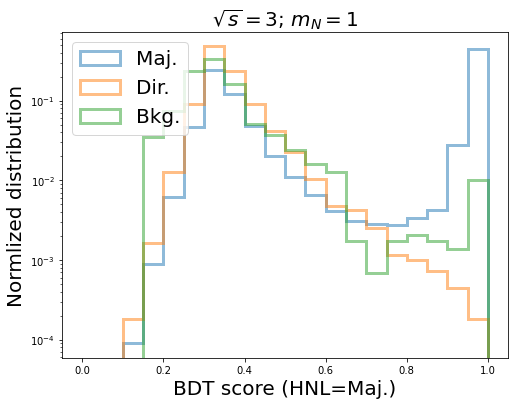

In [59]:
# BDT score distribution 

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

df_plot = df_bdt_test_s

range_=[0, 1]
bins_=20

ax1.hist(df_plot[df_plot.target==1]['pred1'], weights=df_plot[df_plot.target==1]['weight']/sum(df_plot[df_plot.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Maj.', alpha=0.5, color='C0');
ax1.hist(df_plot[df_plot.target==2]['pred1'], weights=df_plot[df_plot.target==2]['weight']/sum(df_plot[df_plot.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Dir.', alpha=0.5, color='C1');
ax1.hist(df_plot[df_plot.target==0]['pred1'], weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score (HNL=Maj.)', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=2, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
ax1.set_yscale('log')





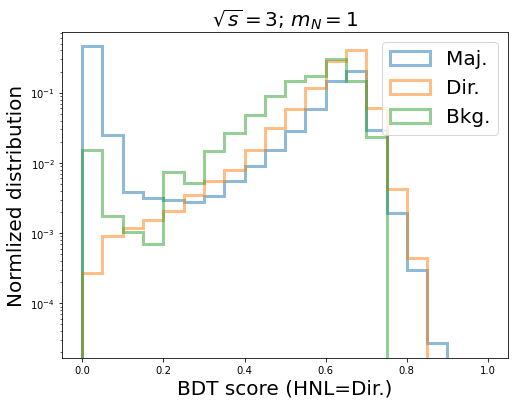

In [60]:
# BDT score distribution 

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

df_plot = df_bdt_test_s

range_=[0, 1]
bins_=20

ax1.hist(df_plot[df_plot.target==1]['pred2'], weights=df_plot[df_plot.target==1]['weight']/sum(df_plot[df_plot.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Maj.', alpha=0.5, color='C0');
ax1.hist(df_plot[df_plot.target==2]['pred2'], weights=df_plot[df_plot.target==2]['weight']/sum(df_plot[df_plot.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Dir.', alpha=0.5, color='C1');
ax1.hist(df_plot[df_plot.target==0]['pred2'], weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score (HNL=Dir.)', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
ax1.set_yscale('log')






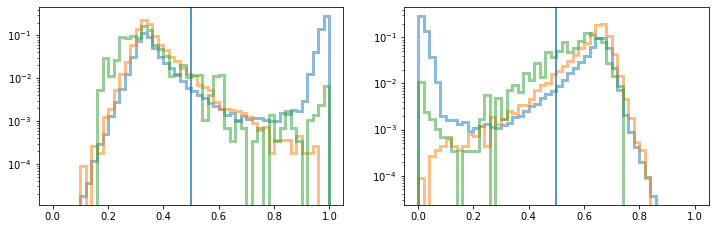

In [61]:
# Distributions of Maj/Dir/bkg. regions

plt.figure(figsize=(12,8))

ax1 = plt.subplot(221)
range_=[0,1]
bins_=50

# Maj. region
ax1.hist(df_bdt_test_s[(df_bdt_test_s.target==1)]['pred1'], weights=df_bdt_test_s[df_bdt_test_s.target==1]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.hist(df_bdt_test_s[(df_bdt_test_s.target==2)]['pred1'], weights=df_bdt_test_s[df_bdt_test_s.target==2]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.hist(df_bdt_test_s[(df_bdt_test_s.target==0)]['pred1'], weights=df_bdt_test_s[df_bdt_test_s.target==0]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
cutM=0.5
ax1.axvline(cutM)
ax1.set_yscale('log')

# Dir. region
ax2 = plt.subplot(222)
range_=[0,1]
ax2.hist(df_bdt_test_s[(df_bdt_test_s.target==1)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==1]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax2.hist(df_bdt_test_s[(df_bdt_test_s.target==2)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==2]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax2.hist(df_bdt_test_s[(df_bdt_test_s.target==0)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==0]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
cutD=0.5
ax2.axvline(cutD)
ax2.set_yscale('log')

# # Bkg. region
# ax3 = plt.subplot(223)
# range_=[0,1]
# ax3.hist(df_bdt_test_s[(df_bdt_test_s.target==1)]['pred1']+df_bdt_test_s[(df_bdt_test_s.target==1)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==1]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
# ax3.hist(df_bdt_test_s[(df_bdt_test_s.target==2)]['pred1']+df_bdt_test_s[(df_bdt_test_s.target==2)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==2]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
# ax3.hist(df_bdt_test_s[(df_bdt_test_s.target==0)]['pred1']+df_bdt_test_s[(df_bdt_test_s.target==0)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==0]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
# # cutD=0.5
# ax3.axvline(threshold)
# ax3.set_yscale('log')

In [62]:
# get the expected yields at the corresponding regions (after BDT and mass cuts)
def get_M_block(V2_test=1e-5):
#     pass Maj. not pass Dir. => Maj. region
    df_M = df_bdt_test_s[(df_bdt_test_s.pred1>cutM) & (df_bdt_test_s.pred2<=cutD)]
#     number of Bkg., Maj., Dir. in the Maj. region
    M0, M1, M2 = df_M[df_M.target==0].weight.sum()/tr_te_size, df_M[df_M.target==1].weight.sum()/tr_te_size, df_M[df_M.target==2].weight.sum()/tr_te_size
#     rescale Maj/Dir by the V2_test
    M1, M2 = M1/V2*V2_test, M2/V2*V2_test
    return M0, M1, M2

def get_D_block(V2_test=1e-5):
#     not pass Maj. pass Dir. => Dir. region
    df_D = df_bdt_test_s[(df_bdt_test_s.pred1<=cutM) & (df_bdt_test_s.pred2>cutD)]
#     number of Bkg., Maj., Dir. in the Maj. region
    D0, D1, D2 = df_D[df_D.target==0].weight.sum()/tr_te_size, df_D[df_D.target==1].weight.sum()/tr_te_size, df_D[df_D.target==2].weight.sum()/tr_te_size
#     rescale Maj/Dir by the V2_test
    D1, D2 = D1/V2*V2_test, D2/V2*V2_test
    return D0, D1, D2

    
# number of events in Maj region
def N_M(r, M_M, D_M, B_M):
    return r*M_M + (1-r)*D_M + B_M
    
# number of events in Dir region
def N_D(r, M_D, D_D, B_D):
    return r*D_D + (1-r)*M_D + B_D

# log likelihood
# r_t: simulated (means if in the real world, the real mixing is r_t); 
# r: r_hat
def lnL(r, r_t, M_M, D_M, B_M, M_D, D_D, B_D):
    NM = N_M(r, M_M, D_M, B_M)
    NMt = N_M(r_t, M_M, D_M, B_M)
    ND = N_D(r, M_D, D_D, B_D)
    NDt = N_D(r_t, M_D, D_D, B_D)
    
    lnL_M = (NMt)*np.log(NM) - (NMt*np.log(NMt)-NMt) - NM
    lnL_D = (NDt)*np.log(ND) - (NDt*np.log(NDt)-NDt) - ND
    return lnL_M + lnL_D

In [63]:
V2_test = upperM
# V2_test = 1e-5
M0, M1, M2 = get_M_block(V2_test)
D0, D1, D2 = get_D_block(V2_test)

r = np.arange(0, 1.0000000001, 0.0001)
rt_lt = np.arange(0, 1.00000000001, 0.01)

def get_bounds(r, sd):
#     significant level
    sig = sd**2
    upper_lt = []
    lower_lt = []

    for i, rt in enumerate(rt_lt):
        if i%100 == 0:
            print(rt, end='\r')
#         array of values of different r (r_hat) with a specific r (simulated r)
        lnL_val = lnL(r, rt, M1, M2, M0, D1, D2, D0)

#         storing the upper bound
        if rt == 1:
            upper_lt.append(np.nan)
        else:
#             find the index of r which gives the closest value to the corresponding significant level
            i_r = np.argmin(abs(lnL_val[np.argmax(lnL_val):] - (np.max(lnL_val)-sig/2))) + np.argmax(lnL_val) 
            if abs(np.max(lnL_val)-sig/2 / lnL_val[i_r] - 1) < 1/100:
                upper_lt.append(r[i_r])
            else: 
                upper_lt.append(np.nan)
        
#         storing the lower bound
        if rt == 0:
            lower_lt.append(np.nan)
        else:
#             find the index of r which gives the closest value to the corresponding significant level
            i_l = np.argmin(abs(lnL_val[:np.argmax(lnL_val)] - (np.max(lnL_val)-sig/2)))
            if abs(np.max(lnL_val)-sig/2 / lnL_val[i_l] - 1) < 1/100:
                lower_lt.append(r[i_l])
            else: 
                lower_lt.append(np.nan)
    
    upper_lt, lower_lt = np.array(upper_lt), np.array(lower_lt)
    return upper_lt, lower_lt

In [64]:
# one sigma
upper_lt1, lower_lt1 = get_bounds(r, 1)
# two sigma
upper_lt2, lower_lt2 = get_bounds(r, 2)

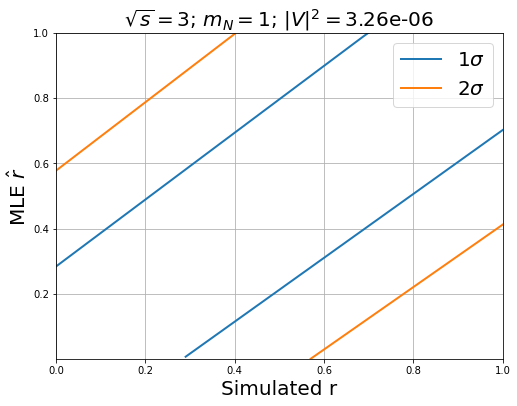

In [65]:

f = plt.figure(figsize=(8,6))

plt.plot(rt_lt, upper_lt1, color='C0', label=r'$1\sigma$', lw=2)
plt.plot(rt_lt, lower_lt1, color='C0', lw=2)

plt.plot(rt_lt, upper_lt2, color='C1', label=r'$2\sigma$', lw=2)
plt.plot(rt_lt, lower_lt2, color='C1', lw=2)

plt.legend(fontsize=20)

plt.title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN)+"; $|V|^2=$"+f"{V2_test:.2e}", fontsize=20)
plt.xlabel("Simulated r", fontsize=20);
plt.ylabel(r"MLE $\hat{r}$", fontsize=20);

plt.margins(y=0)
plt.margins(x=0)

plt.grid()


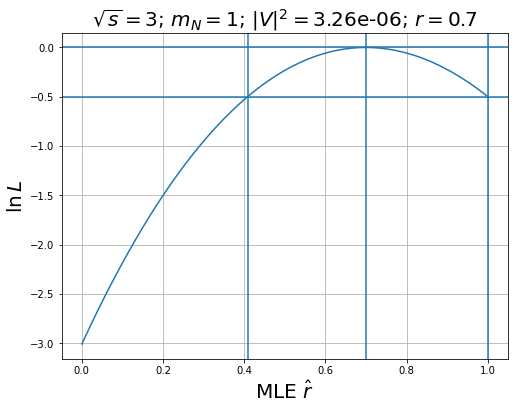

In [66]:
# exmaple of a slide with specific r_t (simulated r)
rt = 0.7   # if the measured data is such value

f = plt.figure(figsize=(8,6))

r = np.arange(0, 1.00000000001, 0.0001)

lnL_val = lnL(r, rt, M1, M2, M0, D1, D2, D0)

plt.plot(r, lnL_val)    # loop over possible r, to find the one max the liklihood
plt.axvline(rt)
plt.axhline(np.max(lnL_val))
plt.axhline(np.max(lnL_val)-1/2)

i_r = np.argmin(abs(lnL_val[np.argmax(lnL_val):] - (np.max(lnL_val)-1/2))) + np.argmax(lnL_val) 
if abs(np.max(lnL_val)-1/2 / lnL_val[i_r] - 1) < 1/100:
    plt.axvline(r[i_r])

i_l = np.argmin(abs(lnL_val[:np.argmax(lnL_val)] - (np.max(lnL_val)-1/2)))
if abs(np.max(lnL_val)-1/2 / lnL_val[i_l] - 1) < 1/100:
    plt.axvline(r[i_l])

    
plt.title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN)+"; $|V|^2=$"+f"{V2_test:.2e}; "+f"$r={rt}$", fontsize=20)
plt.xlabel(r"MLE $\hat{r}$", fontsize=20);
plt.ylabel(r"$\ln{L}$", fontsize=20);
plt.grid()

In [67]:
# width of one sigma (since it is asymmetric, so need to separate upper and lower)
sigma_pos = upper_lt1 - rt_lt
sigma_neg = rt_lt - lower_lt1 

df_sigma = pd.DataFrame(columns=['r', 'sigma_pos', 'sigma_neg'])
df_sigma['r'] = rt_lt
df_sigma['sigma_pos'] = sigma_pos
df_sigma['sigma_neg'] = sigma_neg

df_sigma_pos = df_sigma[['r', 'sigma_pos']].dropna()
df_sigma_neg = df_sigma[['r', 'sigma_neg']].dropna()

# avg of them 
df_sigma['avg'] = df_sigma[['sigma_pos', 'sigma_neg']].mean(axis=1)

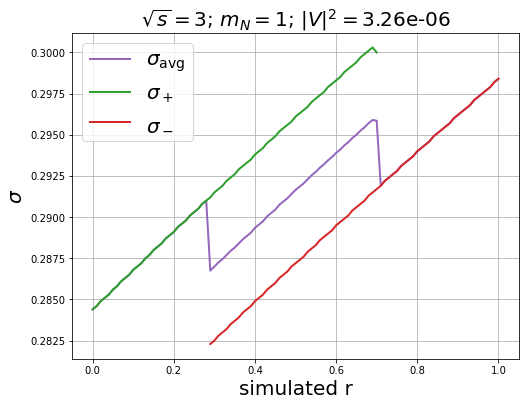

In [68]:

f = plt.figure(figsize=(8,6))
plt.plot(df_sigma['r'], df_sigma['avg'], lw=2, c='C4', label=r'$\sigma_{\rm avg}$')
plt.plot(df_sigma['r'], df_sigma['sigma_pos'], lw=2, c='C2', label=r'$\sigma_+$')
plt.plot(df_sigma['r'], df_sigma['sigma_neg'], lw=2, c='C3', label=r'$\sigma_-$')
plt.legend(fontsize=20)

plt.xlabel("simulated r", fontsize=20);
plt.ylabel(r"$\sigma$", fontsize=20);
plt.title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN)+"; $|V|^2=$"+f"{V2_test:.2e}", fontsize=20)
plt.xlim(-0.05, 1.05)
plt.grid()

In [69]:
# width_thre = 0.1
# sig = 1

# r = np.arange(0, 1.0000000001, 0.0001)
# rt_lt = np.arange(0, 1.00000000001, 0.01)

# V2_dt = {}

# # verbose = 1
# verbose = 0

# for i, rt in enumerate(rt_lt[1:]):
# # for i, rt in enumerate(r[249:]):

#     if not verbose: print(i, rt, "............................................................................................", end='\r')
#     else: print(i, rt, "............................................................................................")
    
    
#     V2_test = 1e-3
#     while True:
#         M0, M1, M2 = get_M_block(V2_test)
#         D0, D1, D2 = get_D_block(V2_test)

#         upper_lt = []
#         lower_lt = []

#         lnL_val = lnL(r, rt, M1, M2, M0, D1, D2, D0)

#         i_r = np.argmin(abs(lnL_val[np.argmax(lnL_val):] - (np.max(lnL_val)-sig/2))) + np.argmax(lnL_val) 
#         if abs(np.max(lnL_val)-sig/2 / lnL_val[i_r] - 1) < 1/100:
#             upper_lt.append(r[i_r])
#         else: 
#             upper_lt.append(np.nan)


#         i_l = np.argmin(abs(lnL_val[:np.argmax(lnL_val)] - (np.max(lnL_val)-sig/2)))
#         if abs(np.max(lnL_val)-sig/2 / lnL_val[i_l] - 1) < 1/100:
#             lower_lt.append(r[i_l])
#         else: 
#             lower_lt.append(np.nan)

#         upper_lt, lower_lt = np.array(upper_lt), np.array(lower_lt)
#         upper_lt[np.isnan(upper_lt)] = 1
#         lower_lt[np.isnan(lower_lt)] = 0

#         width = (upper_lt - lower_lt)[0]
#         if verbose: print(V2_test, width, round(abs(width / width_thre - 1), 8), round(abs(width / width_thre - 1), 8) < 1/100)
#         if round(abs(width / width_thre - 1), 8) < 1/100:
#             if verbose: print("============================================================================================================")
#             V2_dt[rt] = V2_test
#             break
            
#         if width < width_thre and abs(width / width_thre - 1) < 10/100:
#             if verbose: print("/5")
#             V2_test /= (5* (1 + np.random.normal(0, 0.1)))
#         elif width < width_thre and abs(width / width_thre - 1) < 50/100:
#             if verbose: print("/10")
#             V2_test /= (10* (1 + np.random.normal(0, 0.1)))
#         elif width < width_thre :
#             if verbose: print("/20")
#             V2_test /= (20* (1 + np.random.normal(0, 0.1)))
            
#         else:
#             V2_test = 10**(np.log10(V2_test)*0.999) 

In [70]:

# f = plt.figure(figsize=(8,6))
# plt.plot(V2_dt.keys(), V2_dt.values(), lw=2)
# plt.yscale('log')
# plt.margins(y=0.25)
# # plt.ylim(1e-5, 1.5e-4)
# # plt.ylim(1e-5, 1e-3)

# # ax1.set_title(, fontsize=20)
# plt.title(r"min. $|V|^2$ to have $(\sigma_+ - \sigma_-) \leq 0.1$"+"\n"+r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
# plt.xlabel("simulated r", fontsize=20);
# plt.ylabel(r"$|V|^2$", fontsize=20);
# plt.grid()

In [71]:
# get the limit of |V|^2 to reject the null hypothesis H0 (e.g. r0=1 means fully Maj)
def get_limit(r0=1, sd=1):
    rt_lt = np.arange(0,1.00000000001,0.01)

    V2_dt = {}
#     loop over each possible r_t (truth r in the real world)
    for rt in rt_lt:
        if rt==r0:
            V2_dt[rt] = np.nan
            continue
            
#         set some inital V2
        V2_test = 1e-3
        print(rt, end='\r')
        while True:
#             calculate the significance
            M0, M1, M2 = get_M_block(V2_test)
            D0, D1, D2 = get_D_block(V2_test)
            lnL_valr = lnL(rt, rt, M1, M2, M0, D1, D2, D0)
            lnL_val0 = lnL(r0, rt, M1, M2, M0, D1, D2, D0)
            Z = (-2*(lnL_val0 - lnL_valr))**0.5

#             if it is close enough to the targeted signifiant level, 
#             then store the vlaue and stop the loop
            if abs(Z/sd-1) < 0.5/100:
                V2_dt[rt] = V2_test
                break
#              if it is too large, halve the V2 and re calculate the significance 
            elif Z > sd:
                V2_test /= 2
#             if it is too small, make the V2 a little bit larger
            elif Z < sd:
                V2_test = 10**(np.log10(V2_test)*0.999) 
    return V2_dt

In [ ]:
V2_dt_r0_1sd = get_limit(r0=0, sd=1.)
V2_dt_r1_1sd = get_limit(r0=1, sd=1.)

V2_dt_r0_2sd = get_limit(r0=0, sd=2.)
V2_dt_r1_2sd = get_limit(r0=1, sd=2.)

In [ ]:

f = plt.figure(figsize=(8,6))
plt.plot(V2_dt_r0_1sd.keys(), V2_dt_r0_1sd.values(), label=r'$H_0: r=0$ at $1\sigma$', c='C1')
plt.plot(V2_dt_r1_1sd.keys(), V2_dt_r1_1sd.values(), label=r'$H_0: r=1$ at $1\sigma$', c='C0')
plt.plot(V2_dt_r0_2sd.keys(), V2_dt_r0_2sd.values(), label=r'$H_0: r=0$ at $2\sigma$', c='C1', linestyle='--')
plt.plot(V2_dt_r1_2sd.keys(), V2_dt_r1_2sd.values(), label=r'$H_0: r=1$ at $2\sigma$', c='C0', linestyle='--')
plt.yscale('log')
# plt.margins(y=0.25)

# plt.axhline(upperM)

plt.title(r"min. $|V|^2$ to reject $H_0$"+"\n"+r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
plt.xlabel("simulated r", fontsize=20);
plt.ylabel(r"$|V|^2$", fontsize=20);
plt.grid()
plt.legend(fontsize=20)

plt.yscale('log')

In [46]:
# M0, M1, M2 = get_M_block(8.051046480648566e-07)
# D0, D1, D2 = get_D_block(8.051046480648566e-07)

# print(f"Majorana region: B:{M0}; M:{M1}; D:{M2}")
# print(f"Dirac region:    B:{D0}; M:{D1}; D:{D2}")

Majorana region: B:0.0; M:2.939157511987635; D:0.6990934435544011
Dirac region:    B:67.0; M:1.4985935037510099; D:2.966781409261108


In [47]:
# # df_bdt_cut0 = df_bdt_cut[(df_bdt_cut['target'] == 0)]   # Bkg
# # df_bdt_cut1 = df_bdt_cut[(df_bdt_cut['target'] == 1)]   # t-ch M
# # df_bdt_cut2 = df_bdt_cut[(df_bdt_cut['target'] == 2)]   # s-ch M
# # df_bdt_cut3 = df_bdt_cut[(df_bdt_cut['target'] == 3)]   # t-ch D
# # df_bdt_cut4 = df_bdt_cut[(df_bdt_cut['target'] == 4)]   # s-ch D

# # yield (without |V|^2 dependence)
# # nb = df_bdt_cut0.weight.sum() / tr_te_size          # Bkg
# # ntM = df_bdt_cut1.weight.sum() / tr_te_size / V2    # t-ch M
# # nsM = df_bdt_cut2.weight.sum() / tr_te_size / V2    # s-ch M
# # ntD = df_bdt_cut3.weight.sum() / tr_te_size / V2    # t-ch D
# # nsD = df_bdt_cut4.weight.sum() / tr_te_size / V2    # s-ch D

# M0, M1, M2 = get_M_block(1)
# D0, D1, D2 = get_D_block(1)

# nb = M0 + D0
# nM = M2 + D2
# nD = M1 + D1

# # nM = nsM + ntM    # total M
# # nD = nsD + ntD    # total D

# print('yields: ')
# print(f'Bkg:\t{nb:.2e}')
# print(f'(M):\t{nM:.2e}')
# print(f'(D):\t{nD:.2e}')
# print(f'  t-ch (M):\t{ntM:.2e}')
# print(f'  s-ch (M):\t{nsM:.2e}')
# print(f'  t-ch (D):\t{ntD:.2e}')
# print(f'  s-ch (D):\t{nsD:.2e}')

# N = 1.96
# # N = 1.645
# M = N**2

# print('Fully Majorana case:')
# upperM, lowerM = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nM), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nM)
# print(f"upper limit on |V|^2: {upperM:.2e}")
# print(f"lower limit on |V|^2: {lowerM:.2e}")
# print()

# print('Fully Dirac case:')
# upperD, lowerD = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nD), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nD)
# print(f"upper limit on |V|^2: {upperD:.2e}")
# print(f"lower limit on |V|^2: {lowerD:.2e}")

yields: 
Bkg:	6.70e+01
(M):	4.55e+06
(D):	5.51e+06
  t-ch (M):	6.70e+06
  s-ch (M):	2.74e+01
  t-ch (D):	6.04e+06
  s-ch (D):	1.42e+01
Fully Majorana case:
upper limit on |V|^2: 3.97e-06
lower limit on |V|^2: -3.13e-06

Fully Dirac case:
upper limit on |V|^2: 3.28e-06
lower limit on |V|^2: -2.58e-06


## Plots

In [42]:
df_plot = pd.concat([df_train, df_test])

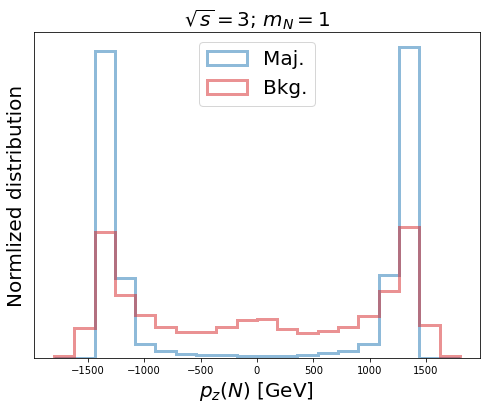

In [65]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[-1800, 1800]
bins_=20

ax1.hist(df_plot[df_plot.target==1]['pzN'], weights=df_plot[df_plot.target==1]['weight']/sum(df_plot[df_plot.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Maj.', alpha=0.5, color='C0');
# ax1.hist(df_plot[df_plot.target==2]['pzN'], weights=df_plot[df_plot.target==2]['weight']/sum(df_plot[df_plot.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Dir.', alpha=0.5, color='C1');
ax1.hist(df_plot[df_plot.target==0]['pzN'], weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C3');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$p_z(N)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=9, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20);

# ax1.set_yscale('log')



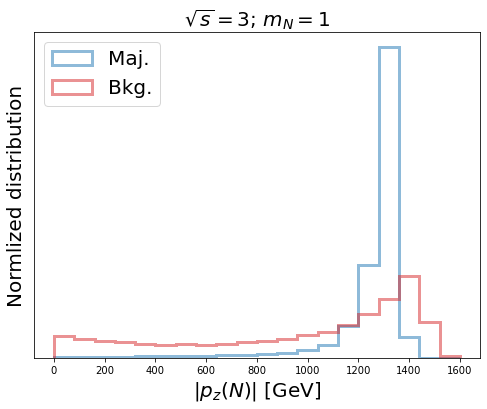

In [163]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[0, 1600]
bins_=20

ax1.hist(abs(df_plot[df_plot.target==1]['pzN']), weights=df_plot[df_plot.target==1]['weight']/sum(df_plot[df_plot.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Maj.', alpha=0.5, color='C0');
# ax1.hist(abs(df_plot[df_plot.target==2]['pzN']), weights=df_plot[df_plot.target==2]['weight']/sum(df_plot[df_plot.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Dir.', alpha=0.5, color='C1');
ax1.hist(abs(df_plot[df_plot.target==0]['pzN']), weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C3');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$|p_z(N)|$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=2, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20);

# ax1.set_yscale('log')



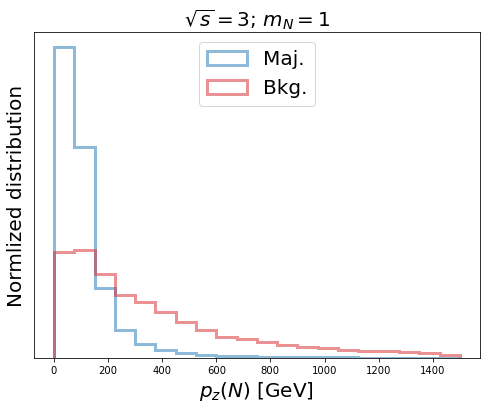

In [156]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[0, 1500]
bins_=20

ax1.hist(df_plot[df_plot.target==1]['ptN'], weights=df_plot[df_plot.target==1]['weight']/sum(df_plot[df_plot.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Maj.', alpha=0.5, color='C0');
# ax1.hist(df_plot[df_plot.target==2]['ptN'], weights=df_plot[df_plot.target==2]['weight']/sum(df_plot[df_plot.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Dir.', alpha=0.5, color='C1');
ax1.hist(df_plot[df_plot.target==0]['ptN'], weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C3');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$p_z(N)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=9, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20);

# ax1.set_yscale('log')



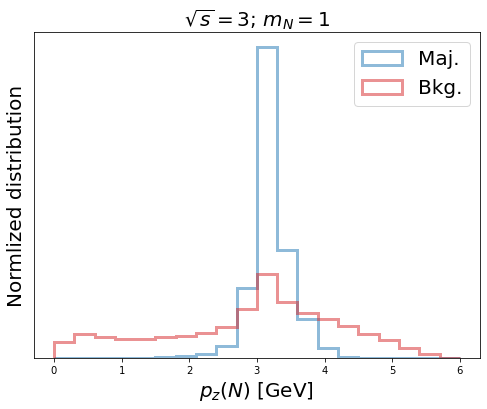

In [161]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[0, 6]
bins_=20

ax1.hist(df_plot[df_plot.target==1]['DeltaRjjl'], weights=df_plot[df_plot.target==1]['weight']/sum(df_plot[df_plot.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Maj.', alpha=0.5, color='C0');
# ax1.hist(df_plot[df_plot.target==2]['DeltaRjjl'], weights=df_plot[df_plot.target==2]['weight']/sum(df_plot[df_plot.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Dir.', alpha=0.5, color='C1');
ax1.hist(df_plot[df_plot.target==0]['DeltaRjjl'], weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C3');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$p_z(N)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20);

# ax1.set_yscale('log')



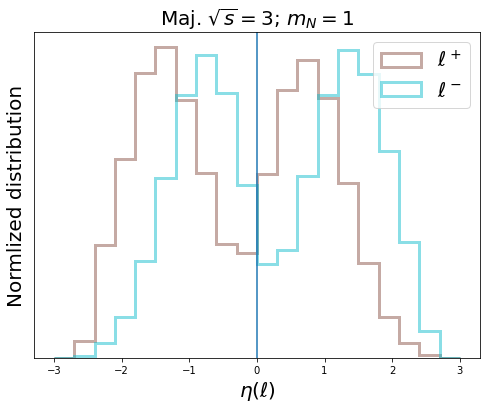

In [100]:


f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[-3, 3]
bins_=20

ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==1)]['etaLep'], weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==1)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.chargeLep==1)]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^+$', alpha=0.5, color='C5');
ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1)]['etaLep'], weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1)]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^-$', alpha=0.5, color='C9');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\eta(\ell)$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"Maj. $\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20);
ax1.axvline(0)
# ax1.set_yscale('log')



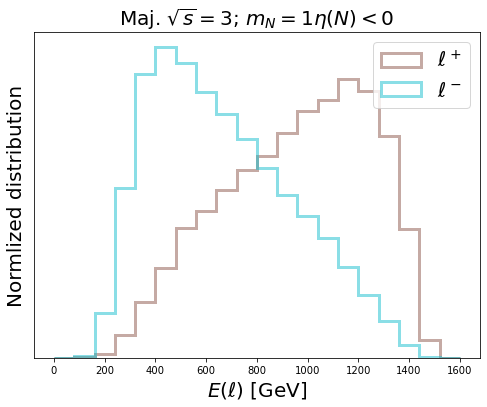

In [114]:


f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[0, 1600]
bins_=20

ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==1) & (df_plot.etaN<0)]['ELep'], 
         weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==1) & (df_plot.etaN<0)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.chargeLep==1) & (df_plot.etaN<0)]['weight']), 
         bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^+$', alpha=0.5, color='C5');

ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1) & (df_plot.etaN<0)]['ELep'], 
         weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1) & (df_plot.etaN<0)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1) & (df_plot.etaN<0)]['weight']), 
         bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^-$', alpha=0.5, color='C9');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$E(\ell)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"Maj. $\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN) + "; $\eta(N)<0$", fontsize=20);
# ax1.set_yscale('log')



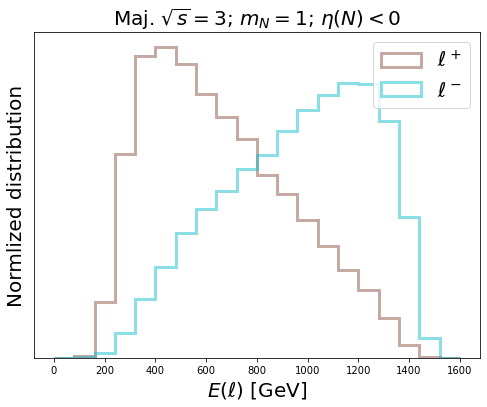

In [125]:


f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[0, 1600]
bins_=20

ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==1) & (df_plot.etaN>0)]['ELep'], 
         weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==1) & (df_plot.etaN>0)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.chargeLep==1) & (df_plot.etaN>0)]['weight']), 
         bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^+$', alpha=0.5, color='C5');

ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1) & (df_plot.etaN>0)]['ELep'], 
         weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1) & (df_plot.etaN>0)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1) & (df_plot.etaN>0)]['weight']), 
         bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^-$', alpha=0.5, color='C9');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$E(\ell)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"Maj. $\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN) + "; $\eta(N)<0$", fontsize=20);
# ax1.set_yscale('log')



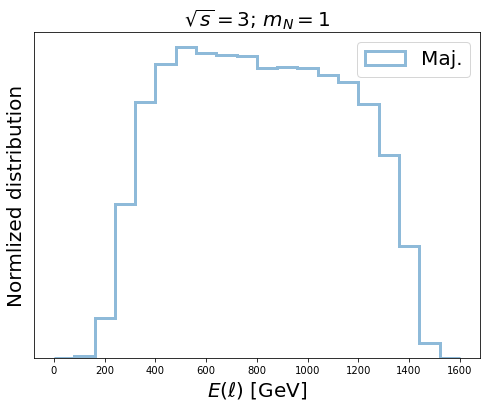

In [126]:


f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[0, 1600]
bins_=20

ax1.hist(df_plot[(df_plot.target==1)]['ELep'], 
         weights=df_plot[(df_plot.target==1)]['weight']/sum(df_plot[(df_plot.target==1)]['weight']), 
         bins=bins_, range=range_, histtype='step', lw=3, label=r'Maj.', alpha=0.5, color='C0');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$E(\ell)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN) , fontsize=20);
# ax1.set_yscale('log')



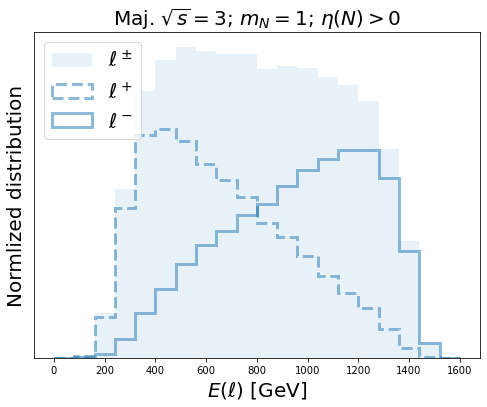

In [167]:


f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[0, 1600]
bins_=20

ax1.hist(df_plot[(df_plot.target==1) & (df_plot.etaN>0)]['ELep'], 
         weights=df_plot[(df_plot.target==1) & (df_plot.etaN>0)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.etaN>0)]['weight']), 
         bins=bins_, range=range_, lw=3, label=r'$\ell^\pm$', alpha=0.1, color='C0');

ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==1) & (df_plot.etaN>0)]['ELep'], 
         weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==1) & (df_plot.etaN>0)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.etaN>0)]['weight']), 
         bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^+$', alpha=0.5, color='C0', linestyle='--');

ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1) & (df_plot.etaN>0)]['ELep'], 
         weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1) & (df_plot.etaN>0)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.etaN>0)]['weight']), 
         bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^-$', alpha=0.5, color='C0');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$E(\ell)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=2, fontsize=20)
ax1.set_title(r"Maj. $\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN) + "; $\eta(N)>0$", fontsize=20);
# ax1.set_yscale('log')



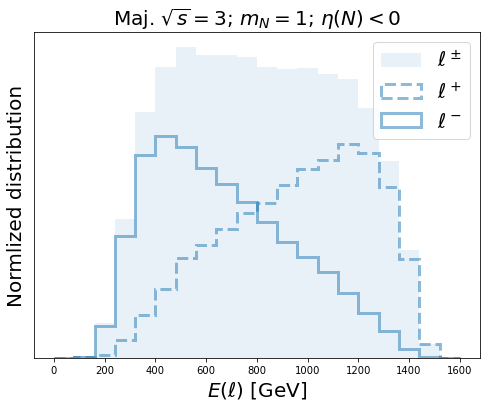

In [168]:


f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[0, 1600]
bins_=20

ax1.hist(df_plot[(df_plot.target==1) & (df_plot.etaN<0)]['ELep'], 
         weights=df_plot[(df_plot.target==1) & (df_plot.etaN<0)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.etaN<0)]['weight']), 
         bins=bins_, range=range_, lw=3, label=r'$\ell^\pm$', alpha=0.1, color='C0');

ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==1) & (df_plot.etaN<0)]['ELep'], 
         weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==1) & (df_plot.etaN<0)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.etaN<0)]['weight']), 
         bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^+$', alpha=0.5, color='C0', linestyle='--');

ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1) & (df_plot.etaN<0)]['ELep'], 
         weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1) & (df_plot.etaN<0)]['weight']/sum(df_plot[(df_plot.target==1) & (df_plot.etaN<0)]['weight']), 
         bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^-$', alpha=0.5, color='C0');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$E(\ell)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"Maj. $\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN) + "; $\eta(N)<0$", fontsize=20);
# ax1.set_yscale('log')



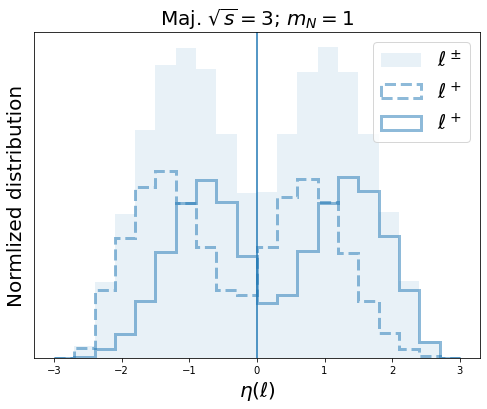

In [169]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[-3, 3]
bins_=20

ax1.hist(df_plot[(df_plot.target==1)]['etaLep'], weights=df_plot[(df_plot.target==1)]['weight']/sum(df_plot[(df_plot.target==1)]['weight']), bins=bins_, range=range_, lw=3, label=r'$\ell^\pm$', alpha=0.1, color='C0');
ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==1)]['etaLep'], weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==1)]['weight']/sum(df_plot[(df_plot.target==1)]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^+$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1)]['etaLep'], weights=df_plot[(df_plot.target==1) & (df_plot.chargeLep==-1)]['weight']/sum(df_plot[(df_plot.target==1)]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'$\ell^+$', alpha=0.5, color='C0');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\eta(\ell)$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"Maj. $\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20);
ax1.axvline(0)
# ax1.set_yscale('log')

